# Importing Necessary Libraries

In [1]:
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA 
from IPython.display import display, HTML
from sklearn.preprocessing import minmax_scale

from sklearn.cluster import KMeans, BisectingKMeans, AgglomerativeClustering, Birch

from sklearn.metrics import silhouette_samples, silhouette_score, rand_score, adjusted_rand_score, mutual_info_score, adjusted_mutual_info_score, calinski_harabasz_score, davies_bouldin_score
from yellowbrick.cluster import KElbowVisualizer
import warnings
warnings.filterwarnings("ignore")

# Loading Indian Pines Dataset and Visualizing Ground Truth

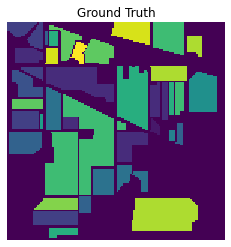

In [2]:
data = scipy.io.loadmat('Data/Indian_pines/Indian_pines_corrected.mat')
ground_truth = scipy.io.loadmat('Data/Indian_pines/Indian_pines_gt.mat')

data_array = np.array(data['indian_pines_corrected'])
gt = ground_truth['indian_pines_gt']

plt.imshow(gt, interpolation='nearest')
plt.title('Ground Truth')
plt.axis('off')
plt.show()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

# Dimensionality Reduction

In [3]:
data_array_flat = data_array.reshape(-1,200)
pca = PCA(n_components=10)
pca.fit(data_array_flat)
data_array_pca = pca.transform(data_array_flat)

gt_reshaped = gt.flatten()
selected_components = pca.fit_transform(data_array_flat)

## Optimal Number of Clusters

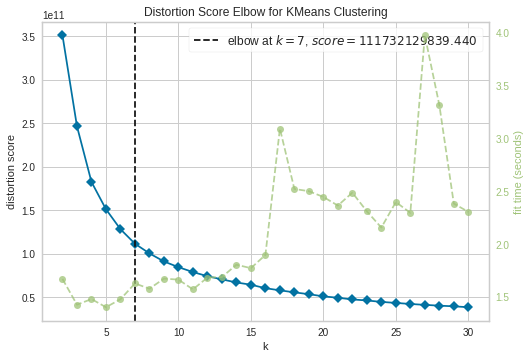

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [23]:
visualizer = KElbowVisualizer(KMeans(), k=(2, 31), timings=True)
# Fit the data
visualizer.fit(selected_components)
# Finalize and render figure
visualizer.show()

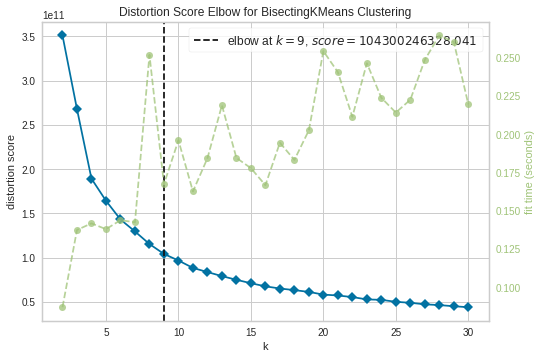

<AxesSubplot:title={'center':'Distortion Score Elbow for BisectingKMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [24]:
visualizer = KElbowVisualizer(BisectingKMeans(), k=(2, 31), timings=True)
# Fit the data
visualizer.fit(selected_components)
# Finalize and render figure
visualizer.show()

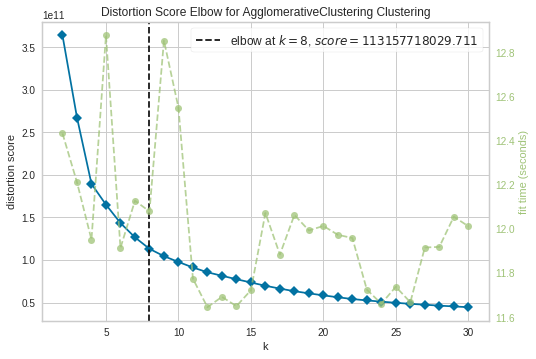

<AxesSubplot:title={'center':'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [25]:
visualizer = KElbowVisualizer(AgglomerativeClustering(), k=(2, 31), timings=True)
# Fit the data
visualizer.fit(selected_components)
# Finalize and render figure
visualizer.show()

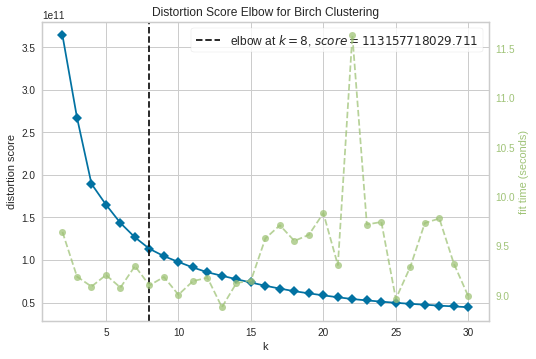

<AxesSubplot:title={'center':'Distortion Score Elbow for Birch Clustering'}, xlabel='k', ylabel='distortion score'>

In [26]:
visualizer = KElbowVisualizer(Birch(), k=(2, 31), timings=True)
# Fit the data
visualizer.fit(selected_components)
# Finalize and render figure
visualizer.show()

# Performance Evaluation 

In [4]:
def performance(cluster, range_n_clusters = list(range(15, 18))):

    columns = ['Number of clusters', 'Average Silhouette score', 'Rand index', 'Adjusted Rand index', 'Mutual Information score',
               'Adjusted Mutual Information score', 'Calinski-Harabasz score', 'Davies-Bouldin score']
    scores = pd.DataFrame(np.zeros((len(range_n_clusters), len(columns))), columns=columns)

    # 3D plots and different scores
    for count, n_clusters in enumerate(range_n_clusters):
        # Create a subplot with 1 row and 2 columns
        fig = plt.figure(figsize=[15, 6])
        ax1 = fig.add_subplot(1, 2, 1)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(selected_components) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        if cluster == 'k-means':
            clusterer = KMeans(n_clusters=n_clusters)
        elif cluster == 'bisecting-k-means':
            clusterer = BisectingKMeans(n_clusters=n_clusters)
        elif cluster == 'agglomerative':
            clusterer = AgglomerativeClustering(n_clusters=n_clusters)
        elif cluster == 'birch':
            clusterer = Birch(n_clusters=n_clusters)
        else :
            return f"Error"
            
        cluster_labels = clusterer.fit_predict(selected_components)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(selected_components, cluster_labels)

        scores_temp = [n_clusters, silhouette_avg,
                       # Similarity score between 0.0 and 1.0, inclusive, 1.0 stands for perfect match.
                       rand_score(gt_reshaped, clusterer.labels_),
                       # Similarity score between -1.0 and 1.0. Random labelings have an ARI close to 0.0. 1.0 stands for perfect match.
                       adjusted_rand_score(gt_reshaped, clusterer.labels_),
                       # Mutual information, a non-negative value, measured in nats using the natural logarithm.
                       mutual_info_score(gt_reshaped, clusterer.labels_),
                       # The AMI returns a value of 1 when the two partitions are identical (ie perfectly matched).
                       # Random partitions (independent labellings) have an expected AMI around 0 on average
                       # hence can be negative. The value is in adjusted nats (based on the natural logarithm).
                       adjusted_mutual_info_score(gt_reshaped, clusterer.labels_),
                       # The resulting Calinski-Harabasz score.
                       calinski_harabasz_score(selected_components, clusterer.labels_),
                       # The resulting Davies-Bouldin score.
                       # The minimum score is zero, and the lower values the better clustering performance.
                       davies_bouldin_score(selected_components, clusterer.labels_)]

        scores.iloc[[count]] = scores_temp

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(selected_components, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title('The silhouette plot for the various clusters.')
        ax1.set_xlabel('The silhouette coefficient values')
        ax1.set_ylabel('Cluster label')

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color='red', linestyle='--')

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        ax2 = fig.add_subplot(1, 2, 2, projection='3d')
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(
            selected_components[:, 0], selected_components[:, 1], selected_components[:, 2],
            marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k'
        )

        ax2.set_title('The visualization of the clustered data.')
        ax2.set_xlabel('Feature space for the 1st feature')
        ax2.set_ylabel('2nd feature')
        ax2.set_zlabel('3rd feature')

        plt.suptitle(
            'Silhouette analysis for {} clustering on sample data with n_clusters = %d'.format(cluster)
            % n_clusters,
            fontsize=14,
            fontweight='bold',
        )

        fig.subplots_adjust(wspace=0, hspace=0)

    plt.show()
    
    return scores

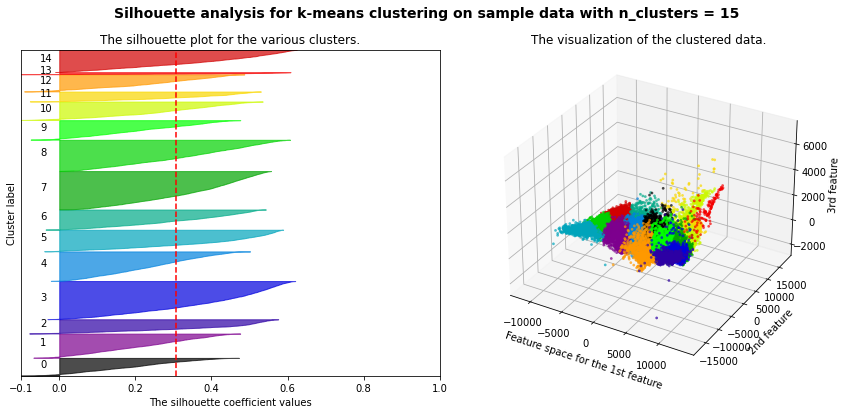

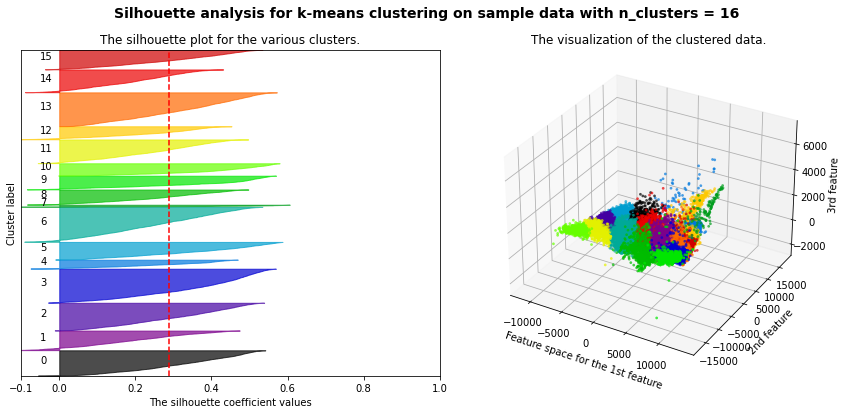

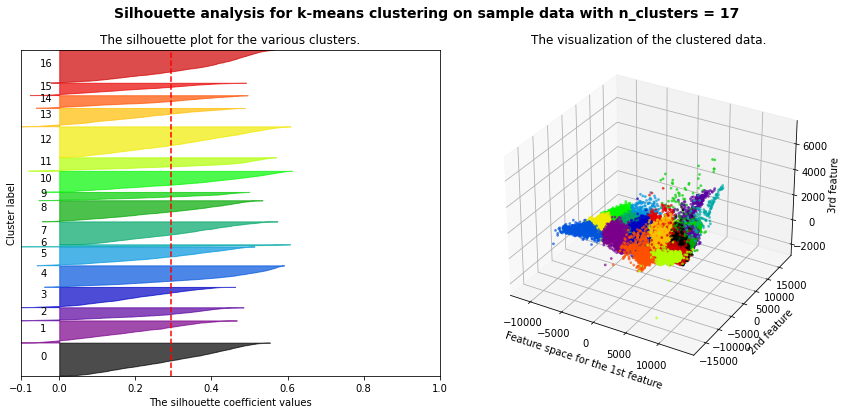

Number of clusters,Average Silhouette score,Rand index,Adjusted Rand index,Mutual Information score,Adjusted Mutual Information score,Calinski-Harabasz score,Davies-Bouldin score
15.0,0.306681,0.693054,0.055267,0.630131,0.282955,17365.078030,1.001393
16.0,0.288198,0.697190,0.062983,0.630686,0.279384,16848.782333,1.051403
17.0,0.293279,0.696167,0.052871,0.645019,0.281117,16742.857140,1.011807


In [6]:
score = performance(cluster='k-means')
display(HTML(score.to_html(index=False)))

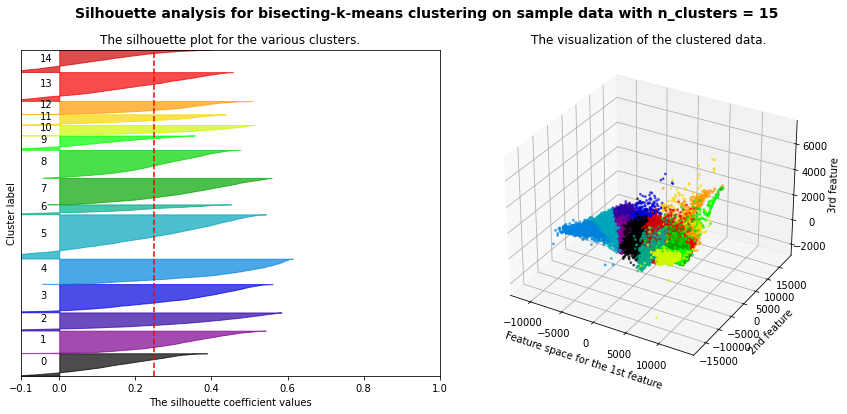

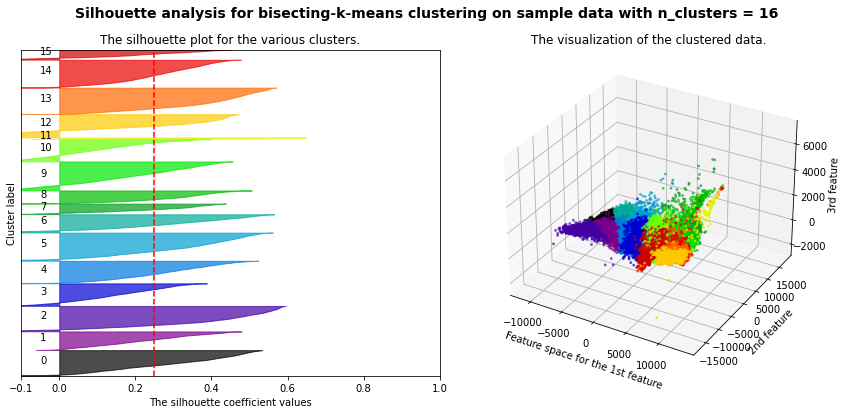

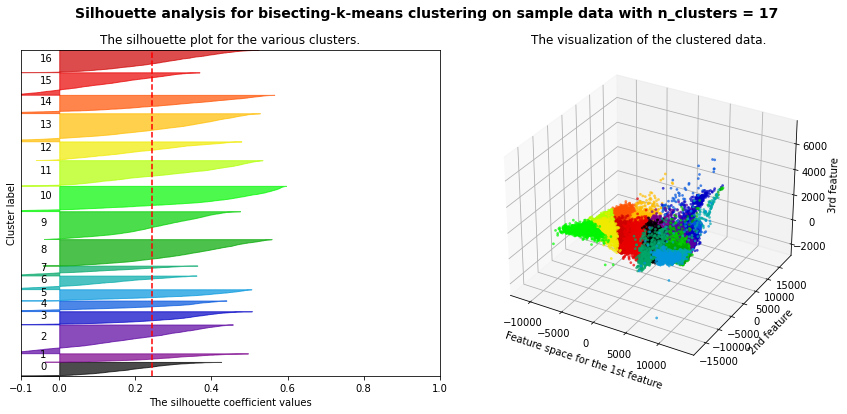

Number of clusters,Average Silhouette score,Rand index,Adjusted Rand index,Mutual Information score,Adjusted Mutual Information score,Calinski-Harabasz score,Davies-Bouldin score
15.0,0.249176,0.696844,0.065414,0.592614,0.264527,15299.597482,1.218521
16.0,0.247751,0.694776,0.050589,0.607094,0.267367,14918.228850,1.171897
17.0,0.244853,0.696491,0.050454,0.613087,0.265164,14730.118808,1.256783


In [7]:
score = performance(cluster='bisecting-k-means')
display(HTML(score.to_html(index=False)))

KeyboardInterrupt: 

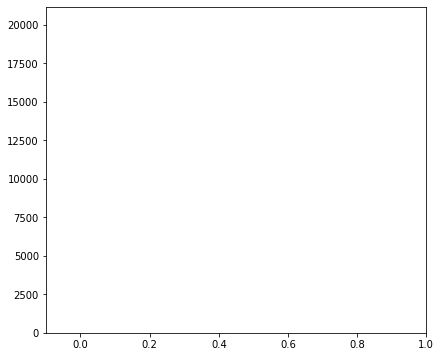

In [8]:
score = performance(cluster='agglomerative')
display(HTML(score.to_html(index=False)))

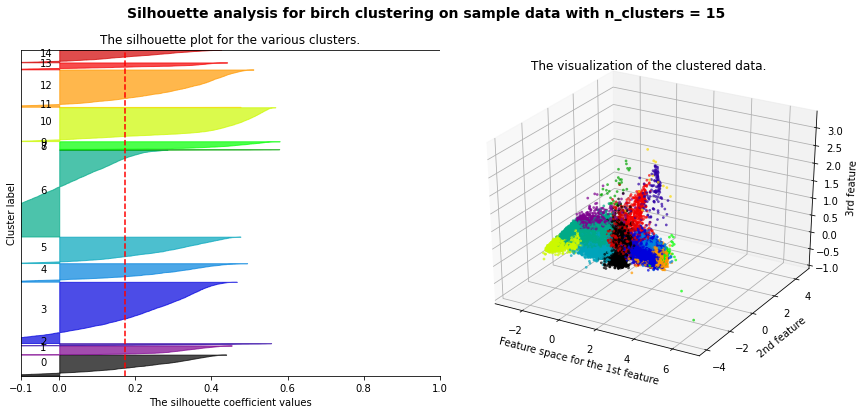

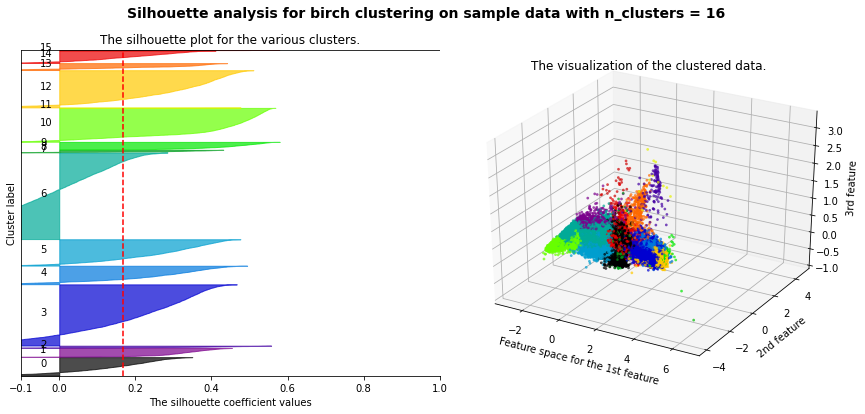

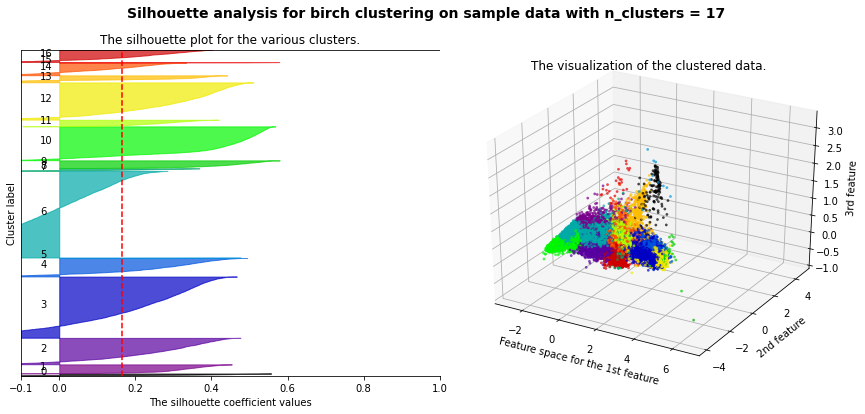

Number of clusters,Average Silhouette score,Rand index,Adjusted Rand index,Mutual Information score,Adjusted Mutual Information score,Calinski-Harabasz score,Davies-Bouldin score
15.0,0.174060,0.682206,0.101935,0.591899,0.296515,10260.867206,1.162352
16.0,0.168066,0.682363,0.101442,0.592926,0.295133,9687.935108,1.214158
17.0,0.165434,0.682818,0.101155,0.606341,0.298952,9269.261361,1.251560


In [ ]:
score = performance(cluster='birch')
display(HTML(score.to_html(index=False)))

# Visualizing Predictions

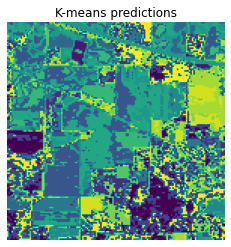

In [ ]:
km = KMeans(n_clusters=16, n_init = 10, max_iter=100)

# use the sklearn kmeans .predict data_array to assign all the pixels of an image to a unique cluster
# rehsape the flattened precition array into an MxN prediction mask
predictions_km = km.fit_predict(data_array_pca).reshape(145,145)

#plot the imagery and the prediction mask for comparison
plt.imshow(predictions_km)
plt.title('K-means predictions')
plt.axis('off')
plt.show()

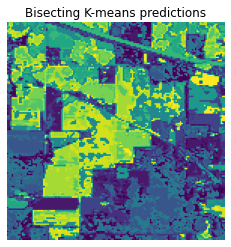

In [ ]:
bkm = BisectingKMeans(n_clusters=16,n_init=10,max_iter=100)

predictions_mask_bkm = bkm.fit_predict(data_array_pca).reshape(145,145)

plt.imshow(predictions_mask_bkm)
plt.axis('off')
plt.title('Bisecting K-means predictions')
plt.show()

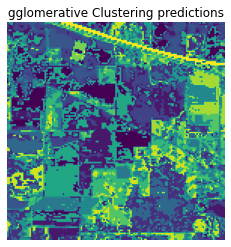

In [ ]:
bkm = AgglomerativeClustering(n_clusters=16)

predictions_mask_bkm = bkm.fit_predict(data_array_pca).reshape(145,145)

plt.imshow(predictions_mask_bkm)
plt.axis('off')
plt.title('Agglomerative Clustering predictions')
plt.show()

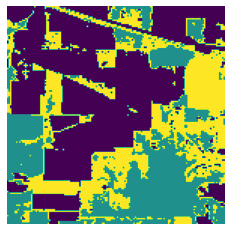

In [ ]:
# Birch 

birch = Birch()
prediction_mask_birch = birch.fit_predict(data_array_pca)
prediction_mask_birch_3d = prediction_mask_birch.reshape(145,145)
plt.imshow(prediction_mask_birch_3d)
plt.axis('off')
plt.show()

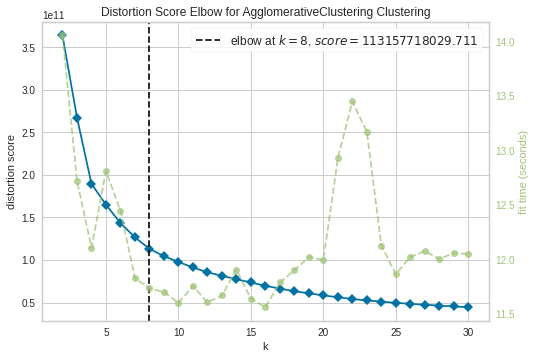

<AxesSubplot:title={'center':'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [14]:
visualizer = KElbowVisualizer(AgglomerativeClustering(), k=(2, 31), timings=True)
# Fit the data
visualizer.fit(selected_components)
# Finalize and render figure
visualizer.show()


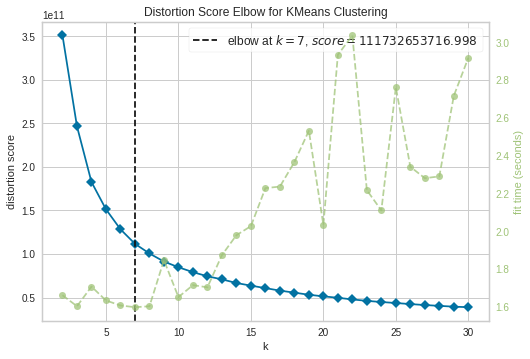

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [21]:
visualizer = KElbowVisualizer(KMeans(), k=(2, 31), timings=True)
# Fit the data
visualizer.fit(selected_components)
# Finalize and render figure
visualizer.show()


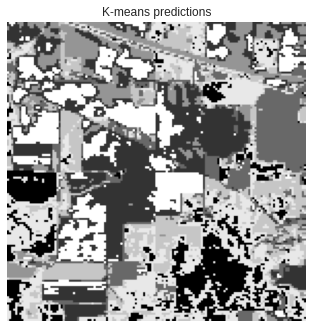

In [22]:
km = KMeans(n_clusters=7, n_init = 10, max_iter=100)

# use the sklearn kmeans .predict data_array to assign all the pixels of an image to a unique cluster
# rehsape the flattened precition array into an MxN prediction mask
predictions_km = km.fit_predict(data_array_pca).reshape(145,145)

#plot the imagery and the prediction mask for comparison
plt.imshow(predictions_km)
plt.title('K-means predictions')
plt.axis('off')
plt.show()